In [1]:
# Importing all the required libraries.
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from numpy import linalg as LA
import imutils 

In [2]:
# Functions to do closing morphological operation (Used from  the assignment 4)
def disk(r):
    k=np.zeros((r,r))
    for i in range(0,r):
        for j in range(0,r):
            if((i-r//2)**2+(j-r//2)**2 <= (r//2)**2):
                k[i][j]=1
    return k

def chkMatch(img,filt):
    [x,y]=img.shape
    for i in range(0,x):
        for j in range(0,y):
            if(filt[i][j]!=0 and filt[i][j]!=img[i][j]):
                return -1
    return 1

def erosion(img,filt):
    [a,b]=img.shape
    [x,y]=filt.shape
    out=img.copy()
    for i in range(x//2,a-x//2):
        for j in range(y//2,b-y//2):
            a=chkMatch(img[i-x//2:i+1+x//2,j-x//2:j+1+x//2],filt)
            if(a==1):
                out[i][j]=255
            else :
                out[i][j]=0
    return out

def chkMatchD(img,filt):
    [x,y]=img.shape
    #print(img)
    #print(filt)
    for i in range(0,x):
        for j in range(0,y):
            if(filt[i][j]!=0 and filt[i][j]==img[i][j]):
                return 1
    return -1

def dilution(img,filt):
    [a,b]=img.shape
    [x,y]=filt.shape
    out=img.copy()
    for i in range(x//2,a-x//2):
        for j in range(y//2,b-y//2):
            a=chkMatchD(img[i-(x//2):i+1+(x//2),j-(x//2):j+1+(x//2)],filt)
            if(a==1):
                out[i][j]=1
            else :
                out[i][j]=0
    return out*255

In [3]:
# Function to read Images

def readImage(path):
    img=Image.open(path).convert('L')
    img.resize((1000,1000))
    return img

# Function to find Homography between two images

def getHomography(img1,img2):
    orig_image = np.array(img1)
    skewed_image = np.array(img2)
    # using surf for feature matching
    try:
        surf = cv2.xfeatures2d.SURF_create(500)
    except Exception:
        surf = cv2.SIFT(500)
    # Finding the matching features between the two images
    kp1,des1 = surf.detectAndCompute(orig_image, None)
    kp2,des2 = surf.detectAndCompute(skewed_image, None)
    # Using the FLANN detector to remove the outliers 
    FLANN_INDEX_KDTREE=0
    index_params=dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params=dict(checks=50)
    flann=cv2.FlannBasedMatcher(index_params, search_params)
    matches=flann.knnMatch(des1,des2,k=2)
    good=[]
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    # Setting the min match count for thr match count of labels 
    MIN_MATCH_COUNT=10
    if len(good)>MIN_MATCH_COUNT:
        src_pts=np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts=np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        H, mask=cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H

# Function to get initial set of points along with distribution of the options

def makePoints():
    # Manually setting up the points for the given template image
    a=[[100,124],[134,124],[166,124],
       [100,145],[134,145],[166,145],
       [100,169],[134,169],[166,169],
       [100,191],[134,191],[166,191],
       [100,212],[134,212],[166,212],[202,212],[235,212],
       [100,234],[134,234],
       [101,257],[134,257],
       [101,279],[134,279],
       [101,302],[134,302],[168,302],
       [101,324],[135,324],[168,324]]
    d=[3,3,3,3,5,2,2,2,3,3]
    return a,d

# Fuction to gets corresponding points if H is known

def getsCorrspondingPoints(points,H):
    points=np.array(points)
    x=points.shape[0]
    # Appending one for the homography to work for the points matching
    point=np.hstack((points,np.ones((x,1))))
    point=point.T
    
    correspondingPoints=np.matmul(H,point)
    correspondingPoints=correspondingPoints.T
    for i in range(0,x):
        correspondingPoints[i][0]=correspondingPoints[i][0]/correspondingPoints[i][2]
        correspondingPoints[i][1]=correspondingPoints[i][1]/correspondingPoints[i][2]
    # Returning the corresponding points for the 2nd image related to 1st image
    return correspondingPoints

# Function to check for answers in the sheet if points known

def checkNeighboursPixels(img,points,a):
    img=np.array(img)
    points=np.array(points)
    points=points.astype('int')
    # Thresholding the image using threshold
    binaryImg=(img<200).astype(np.uint8)
    # To improve our accuracy we do opening to succesfully white circles
    kernel=np.ones((7,7),np.uint8)
    binaryImg=cv2.morphologyEx(binaryImg,cv2.MORPH_OPEN,kernel)
    
    plt.figure(figsize=(8,8))
    plt.imshow(binaryImg,cmap='gray')
    if(a==1):
        plt.title("Points Matching for the Ideal answer sheet")
    else:
        plt.title("Points Matching for the Students answer sheet")
    plt.scatter(points[:,0],points[:,1],s=10)
    plt.show() 
    
    x=points.shape[0]
    n=5
    # finding number of average white pixels around all the points in the inverted image
    answers=np.zeros(x)
    for i in range(0,x):
        ans=0
        for j in range(points[i,0]-n,points[i,0]+n):
            for k in range(points[i,1]-n,points[i,1]+n):
                #plt.scatter(j,k)
                if(binaryImg[k][j]):
                    ans+=1
        answers[i]=ans
    answers=answers>0
    return answers.astype('int')

# Function to gets the answers between two given sheets

def getAnswers(img1,img2,points,a):
    # Find homography Matrix
    homography=getHomography(img1,img2)
    # Find related points in the two image
    correspondingPoints=getsCorrspondingPoints(points,homography)
    
    # Check neighbouring pixels and get whether option is marked or not
    answer=checkNeighboursPixels(img2,correspondingPoints,a)
    return answer

# Function to check the answers from the ideal answer and return right and wrong answers 
def calculateScore(o,y,distribution):
    idd=0
    distribution=np.array(distribution)
    wrong=[]
    right=[]
    for i in range(0,distribution.shape[0]):
        j=0
        for k in range(0,distribution[i]):
            if(o[idd]!=y[idd] and j==0):
                wrong.append(i+1)
                j=1
            idd+=1
        if j==0:
            right.append(i+1)            
    return right,wrong

# Function for ploting the right and wrong answers with different colors
def plotting_final_image_with_color(o,t,img,pts):
    wrong = []
    correct = []
    
    for i in range(np.array(pts).shape[0]):
        if t[i] ==1:
            if o[i] != t[i]:
                wrong.append(pts[i])
            if o[i] == t[i]:
                correct.append(pts[i])
            
    correct = np.array(correct)
    wrong = np.array(wrong)
    #print(correct)
    plt.figure(figsize=(8,8))
    plt.imshow(np.array(img),cmap='gray')
    plt.scatter(correct[:,0],correct[:,1],c = 'g',s=10)
    plt.scatter(wrong[:,0],wrong[:,1],c = 'r',s=10)
    plt.title("Right Answers by Green & Wrong answers by Red and unresponded are left blank")
    plt.show()

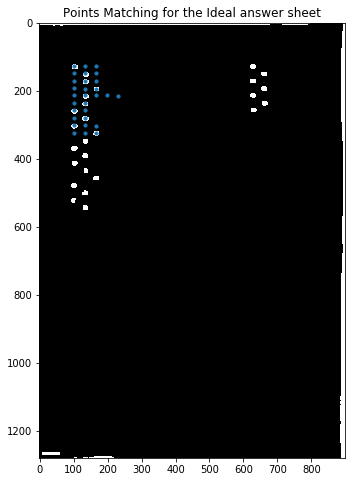

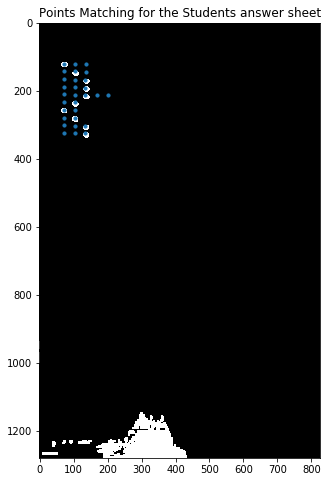

Our observation for the first 10 questions are :
Right answers are:
[1, 2, 4, 6, 7, 8, 10]
Wrong answers or Unresponded are 
[3, 5, 9]


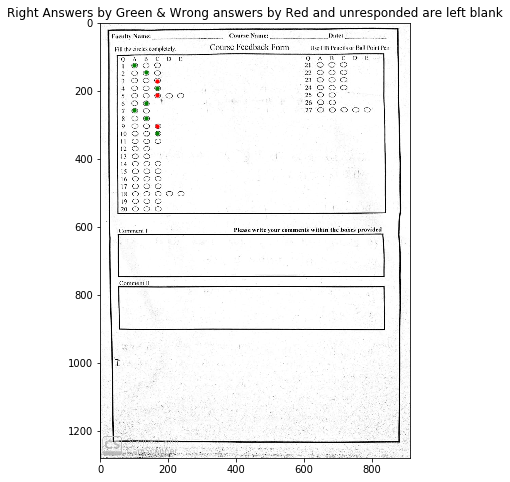

In [7]:
path1='./Dataset/i1.jpeg'
path2='./Dataset/i2.jpeg'
path3='./Dataset/test0.jpeg'

templateImg=readImage(path1)
anskeyImg=readImage(path2)
testImg=readImage(path3)

ansCordinates,distribution=makePoints()

originalAnswers=getAnswers(templateImg,anskeyImg,ansCordinates,1)
testAnswers=getAnswers(templateImg,testImg,ansCordinates,2)

right,wrong=calculateScore(originalAnswers,testAnswers,distribution)
print("Our observation for the first 10 questions are :")
print("Right answers are:")
print(right)
print("Wrong answers or Unresponded are ")
print(wrong)
plotting_final_image_with_color(originalAnswers,testAnswers,templateImg,ansCordinates,)

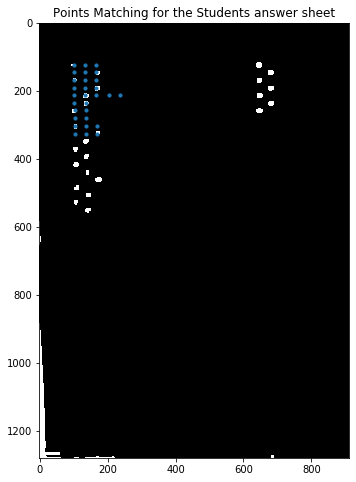

For  1 th image :
Questions with right answers
[1, 4, 5, 6, 7, 9, 10]
Questions with wrong answers
[2, 3, 8]


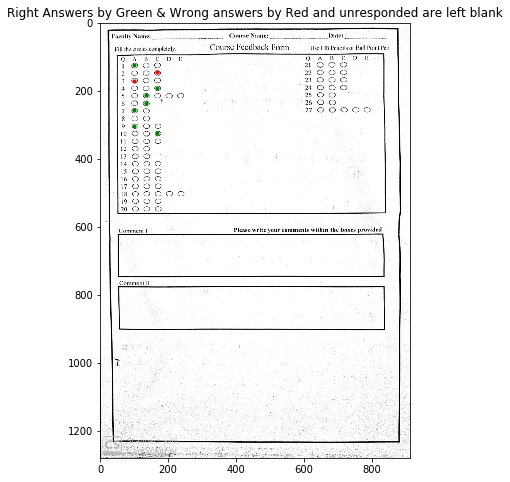

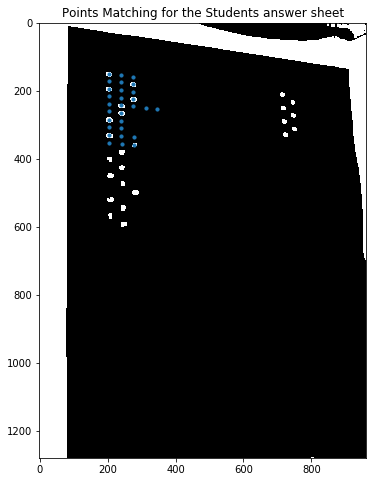

For  2 th image :
Questions with right answers
[1, 4, 5, 6, 7, 9, 10]
Questions with wrong answers
[2, 3, 8]


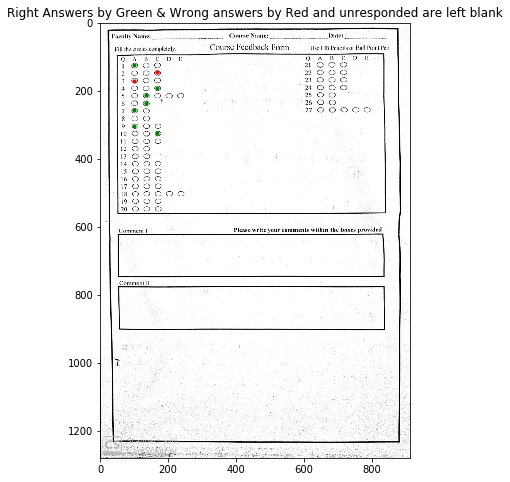

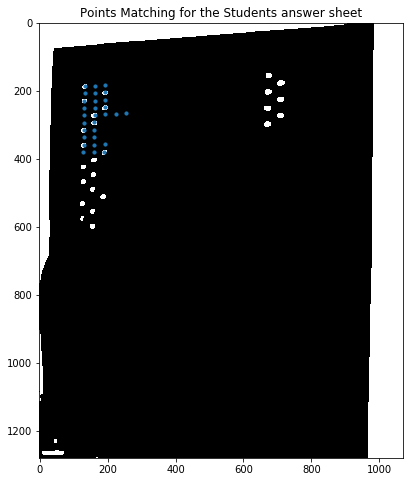

For  3 th image :
Questions with right answers
[1, 4, 5, 6, 7, 9, 10]
Questions with wrong answers
[2, 3, 8]


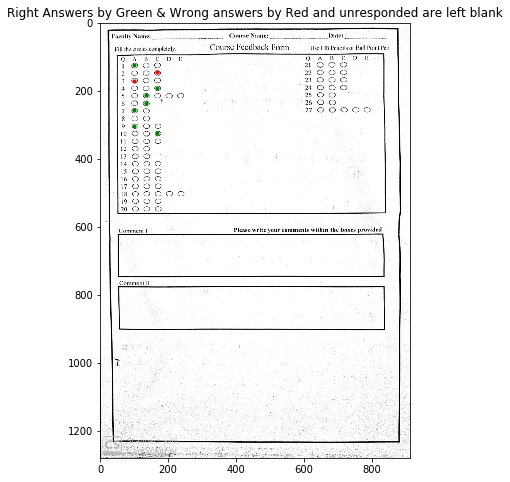

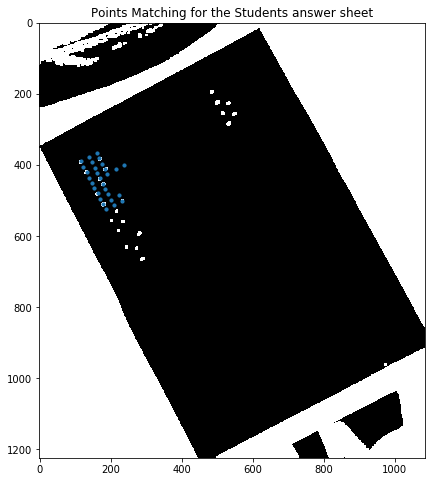

For  4 th image :
Questions with right answers
[1, 4, 5, 6, 7, 9, 10]
Questions with wrong answers
[2, 3, 8]


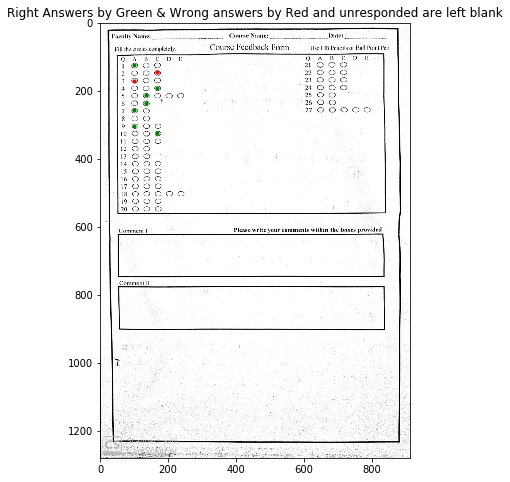

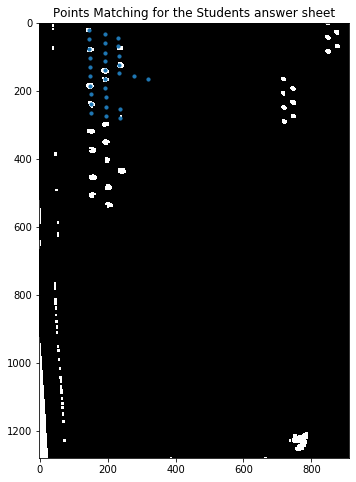

For  5 th image :
Questions with right answers
[1, 4, 5, 6, 7, 9, 10]
Questions with wrong answers
[2, 3, 8]


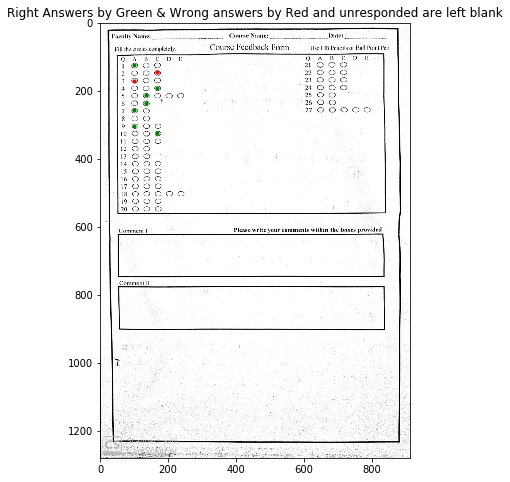

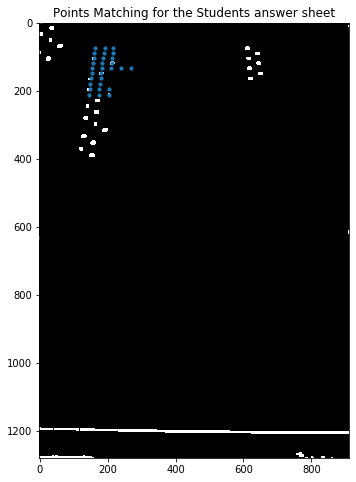

For  6 th image :
Questions with right answers
[4, 5, 6, 7, 9, 10]
Questions with wrong answers
[1, 2, 3, 8]


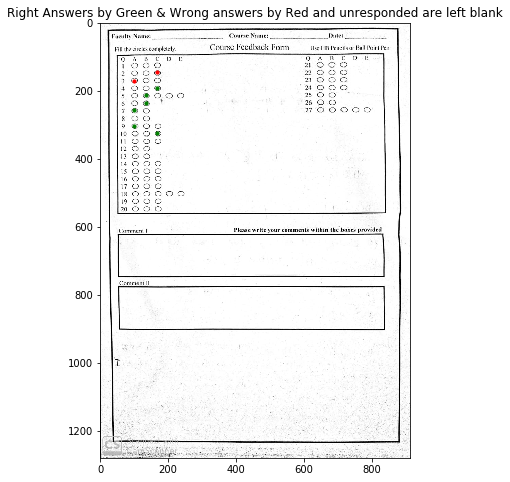

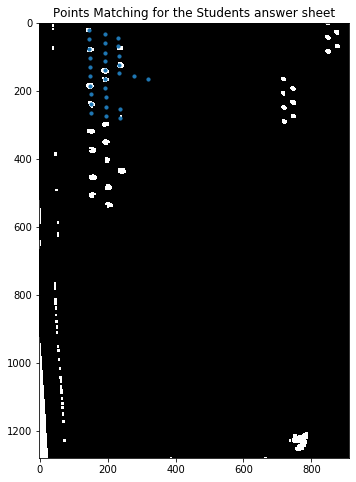

For  7 th image :
Questions with right answers
[1, 4, 5, 6, 7, 9, 10]
Questions with wrong answers
[2, 3, 8]


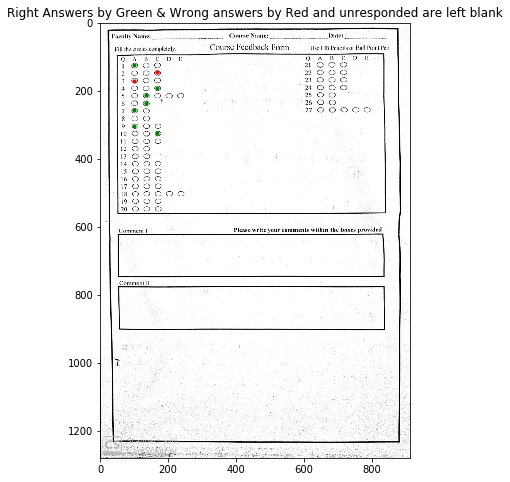

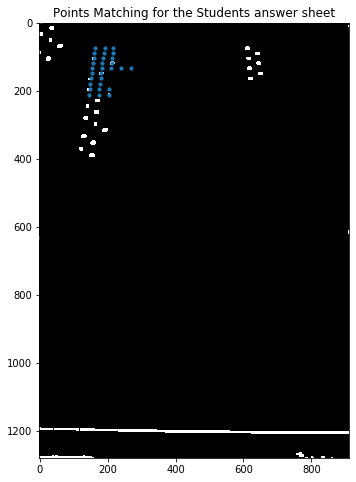

For  8 th image :
Questions with right answers
[4, 5, 6, 7, 9, 10]
Questions with wrong answers
[1, 2, 3, 8]


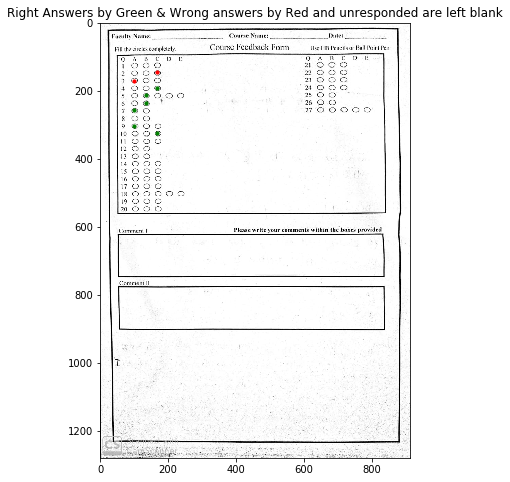

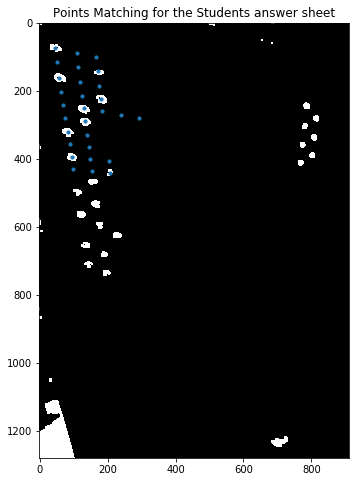

For  9 th image :
Questions with right answers
[1, 4, 5, 6, 7, 9, 10]
Questions with wrong answers
[2, 3, 8]


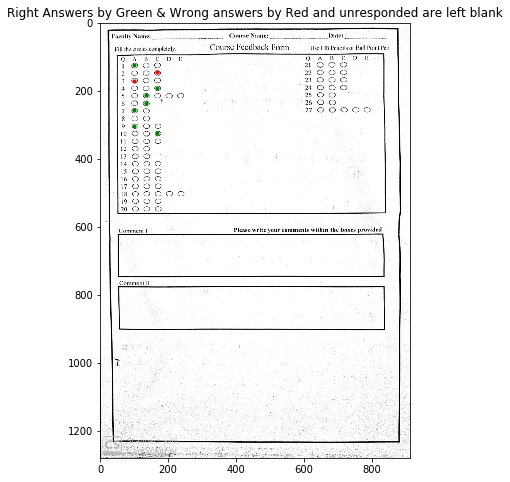

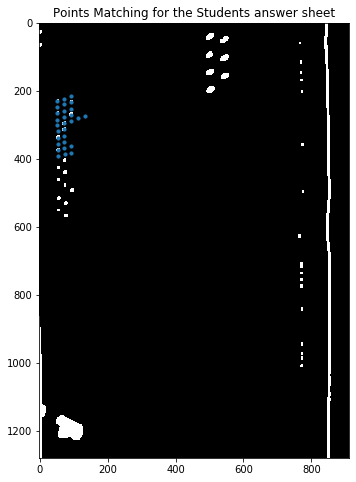

For  10 th image :
Questions with right answers
[1, 4, 5, 6, 7, 9]
Questions with wrong answers
[2, 3, 8, 10]


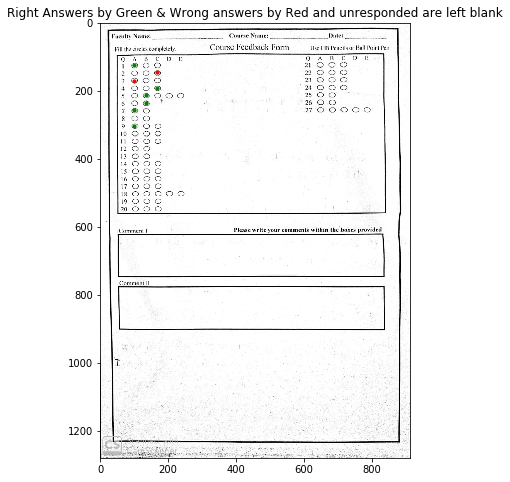

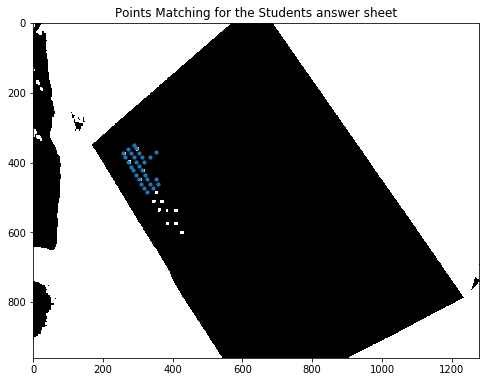

For  11 th image :
Questions with right answers
[1, 6, 7]
Questions with wrong answers
[2, 3, 4, 5, 8, 9, 10]


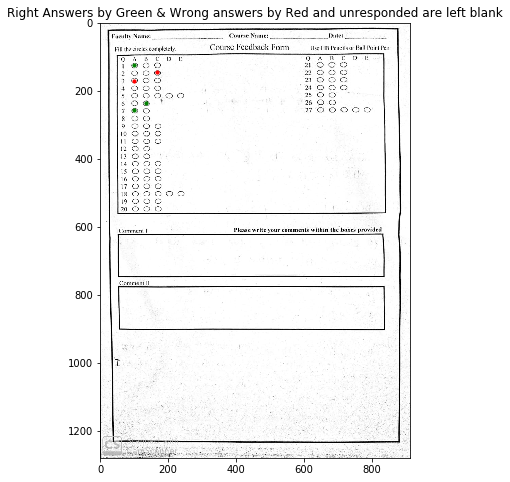

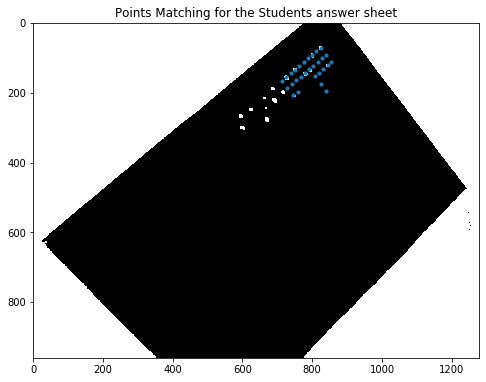

For  12 th image :
Questions with right answers
[1, 5, 6, 7, 9, 10]
Questions with wrong answers
[2, 3, 4, 8]


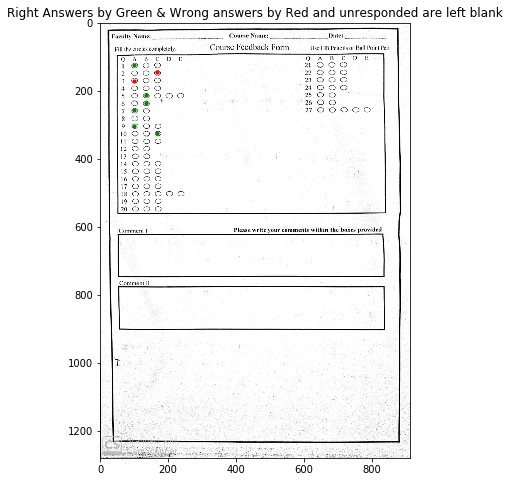

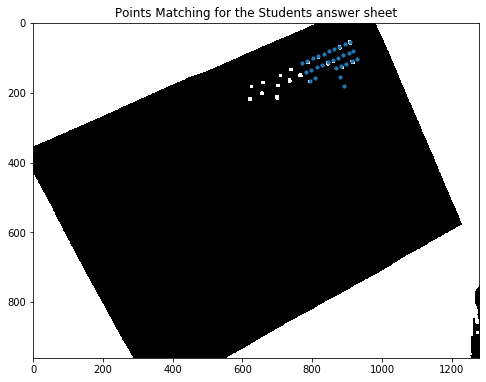

For  13 th image :
Questions with right answers
[1, 4, 5, 6, 7, 9, 10]
Questions with wrong answers
[2, 3, 8]


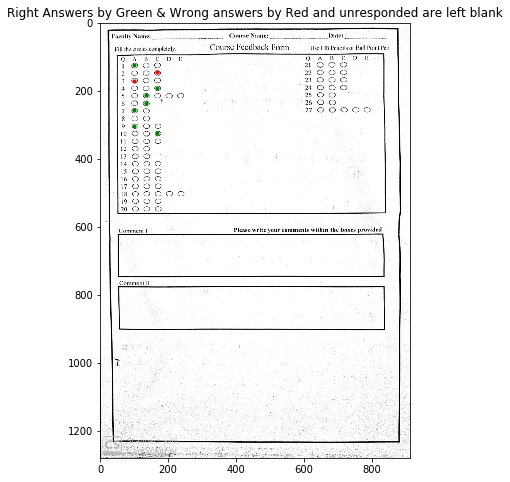

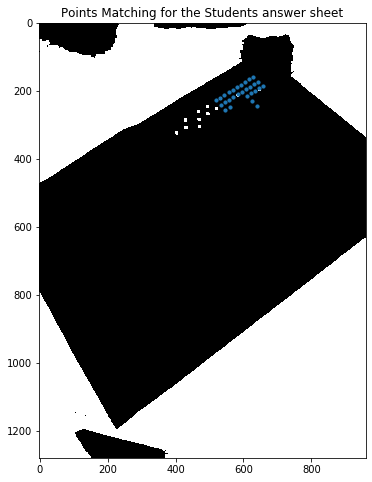

For  14 th image :
Questions with right answers
[6, 9, 10]
Questions with wrong answers
[1, 2, 3, 4, 5, 7, 8]


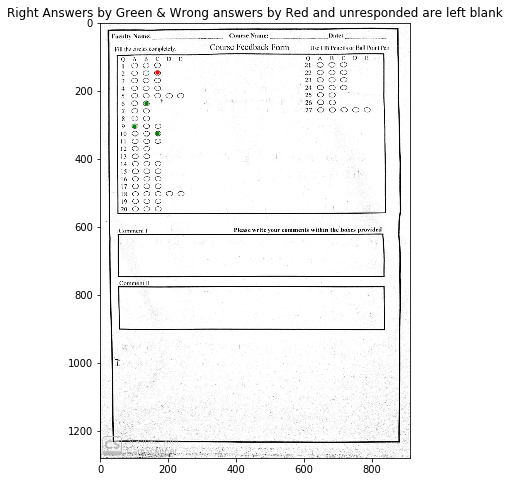

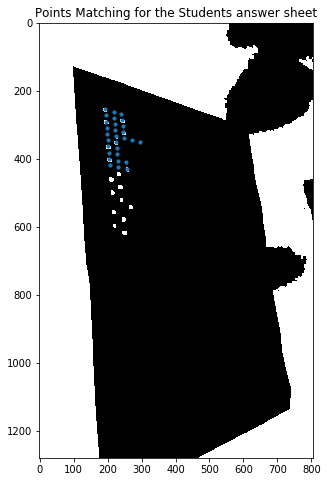

For  15 th image :
Questions with right answers
[1, 4, 5, 6, 7, 9, 10]
Questions with wrong answers
[2, 3, 8]


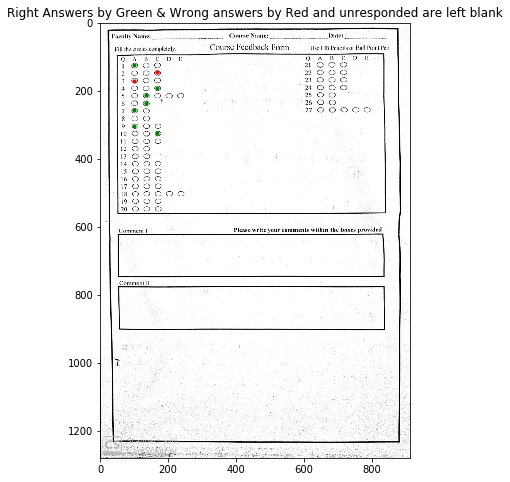

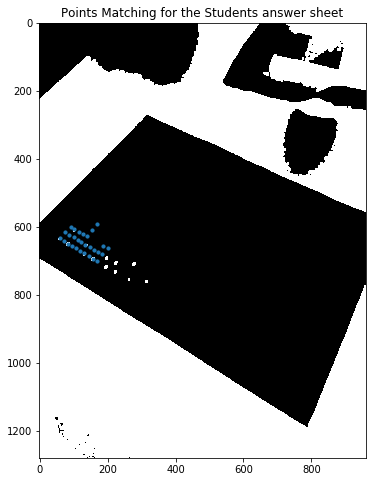

For  16 th image :
Questions with right answers
[1, 4, 6, 9]
Questions with wrong answers
[2, 3, 5, 7, 8, 10]


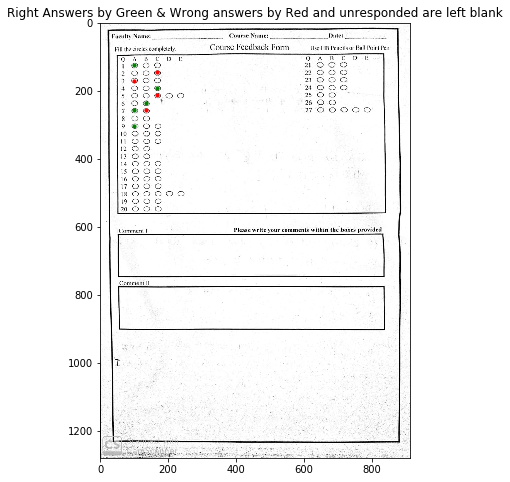

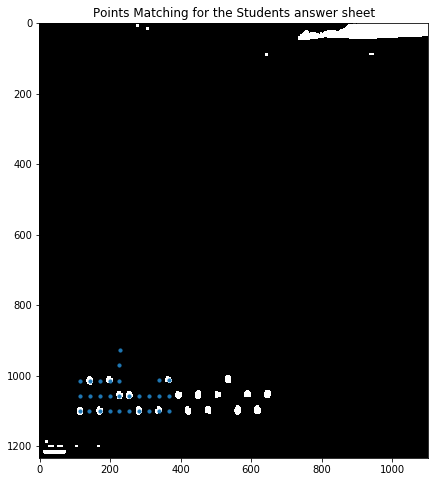

For  17 th image :
Questions with right answers
[1, 4, 5, 6, 7, 9, 10]
Questions with wrong answers
[2, 3, 8]


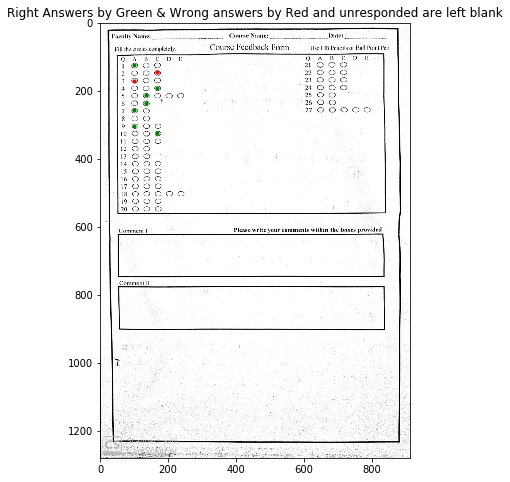

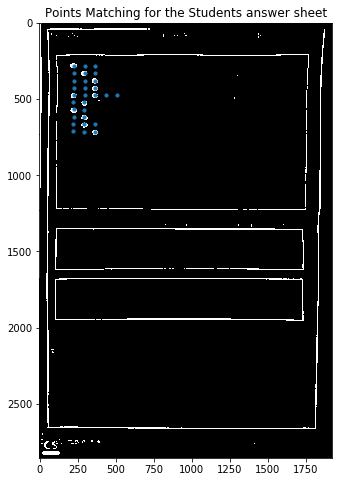

For  18 th image :
Questions with right answers
[1, 2, 4, 6, 7, 8, 10]
Questions with wrong answers
[3, 5, 9]


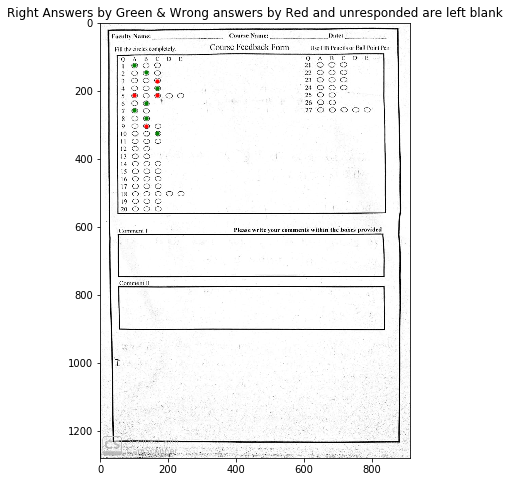

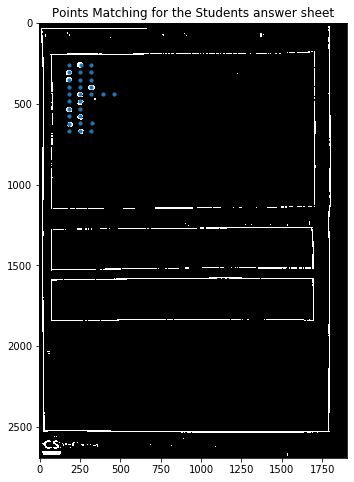

For  19 th image :
Questions with right answers
[4, 5, 6, 7, 8, 9]
Questions with wrong answers
[1, 2, 3, 10]


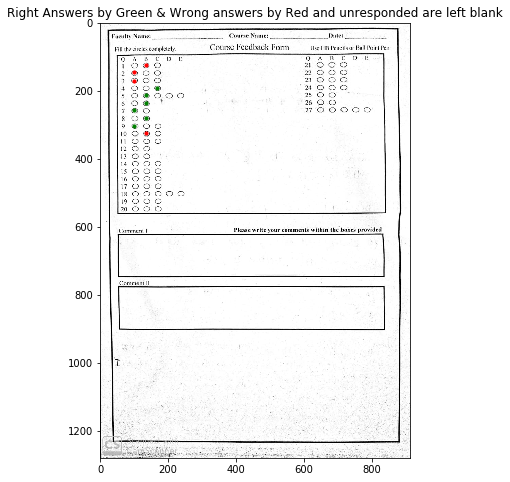

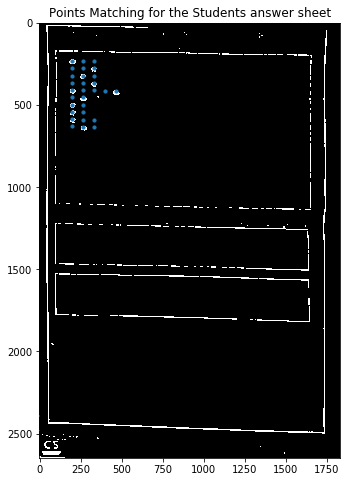

For  20 th image :
Questions with right answers
[1, 3, 4, 6, 7, 9]
Questions with wrong answers
[2, 5, 8, 10]


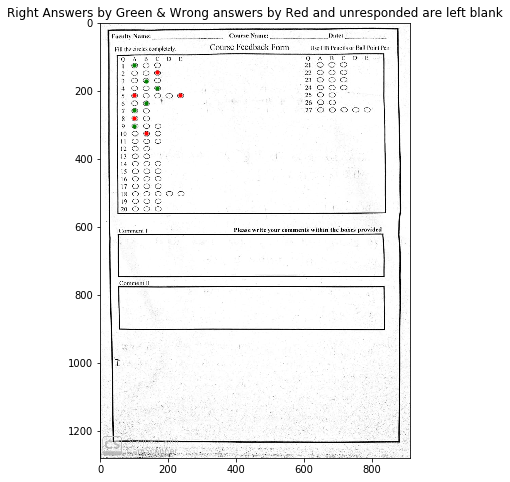

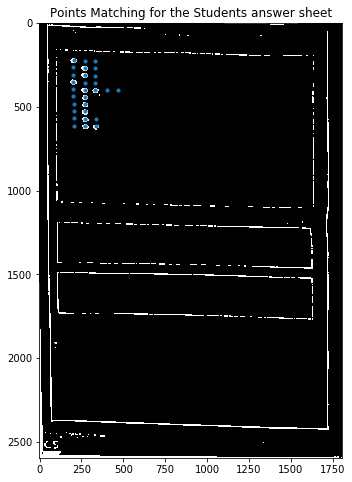

For  21 th image :
Questions with right answers
[1, 2, 3, 6, 8]
Questions with wrong answers
[4, 5, 7, 9, 10]


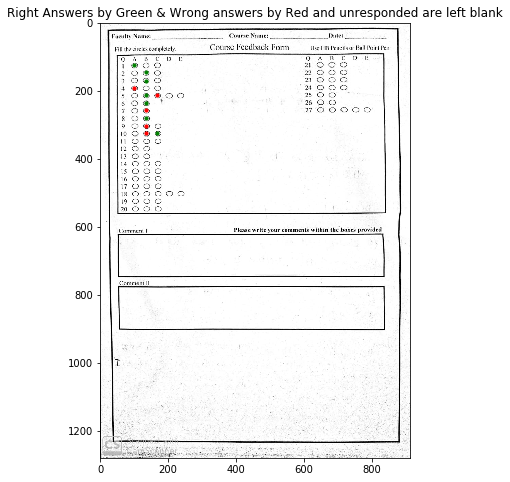

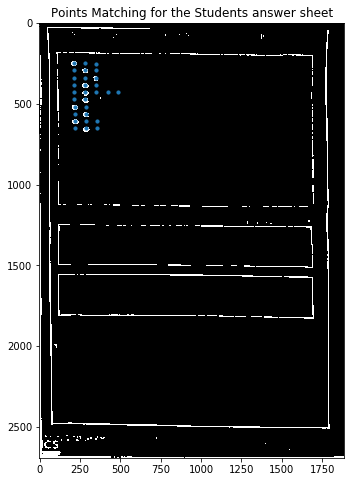

For  22 th image :
Questions with right answers
[1, 2, 5, 6, 7, 8, 9]
Questions with wrong answers
[3, 4, 10]


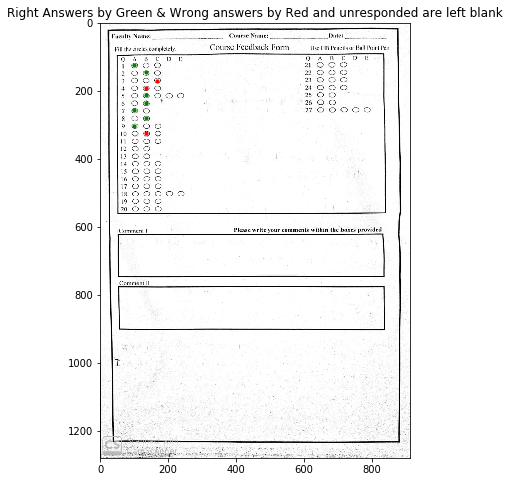

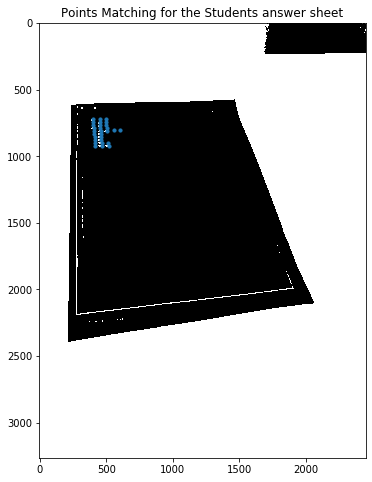

For  23 th image :
Questions with right answers
[1, 2, 3, 6, 8]
Questions with wrong answers
[4, 5, 7, 9, 10]


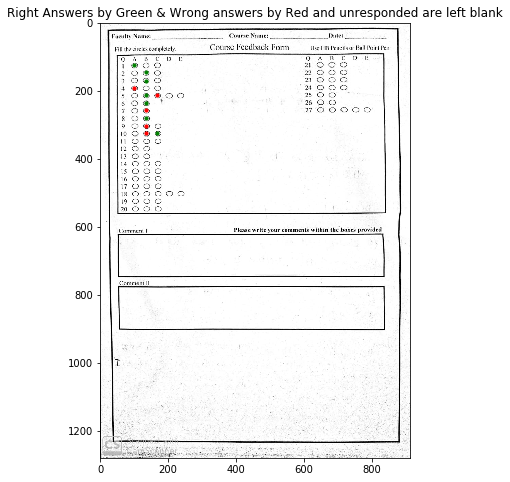

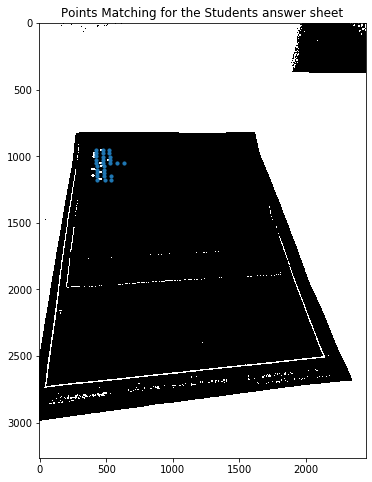

For  24 th image :
Questions with right answers
[4, 5, 6]
Questions with wrong answers
[1, 2, 3, 7, 8, 9, 10]


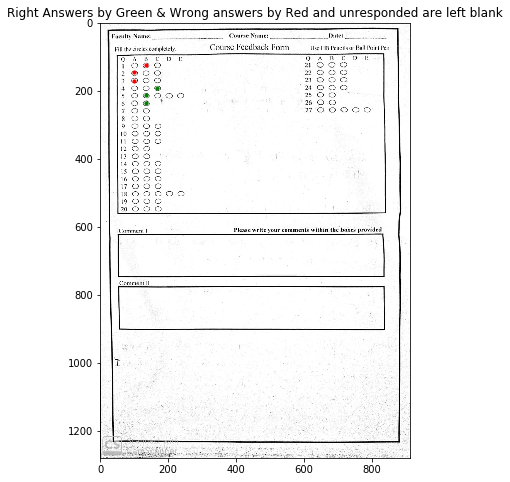

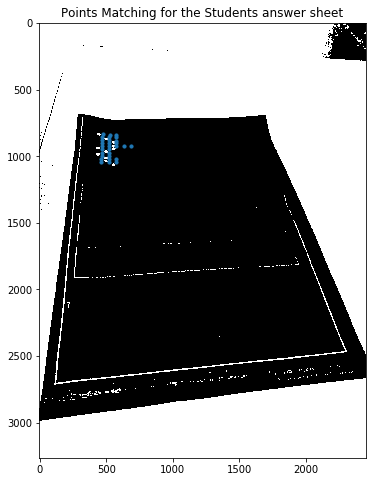

For  25 th image :
Questions with right answers
[4]
Questions with wrong answers
[1, 2, 3, 5, 6, 7, 8, 9, 10]


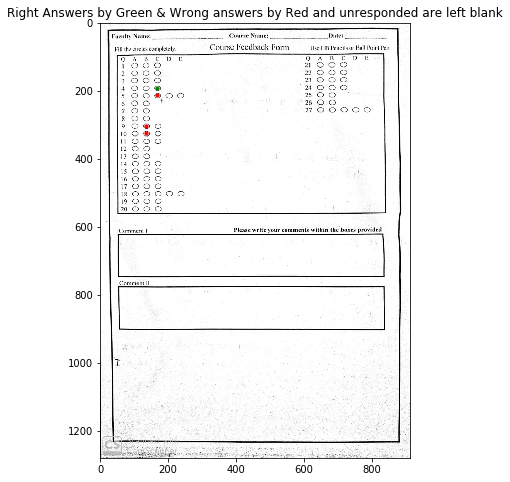

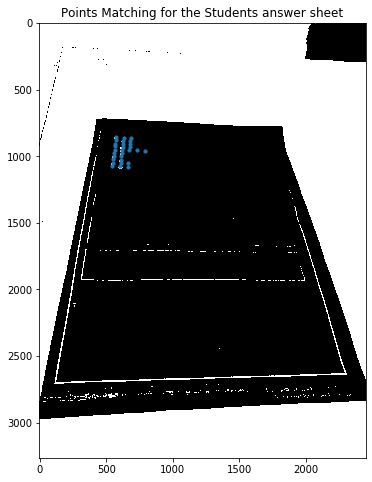

For  26 th image :
Questions with right answers
[1, 2, 5, 6, 7, 8, 9]
Questions with wrong answers
[3, 4, 10]


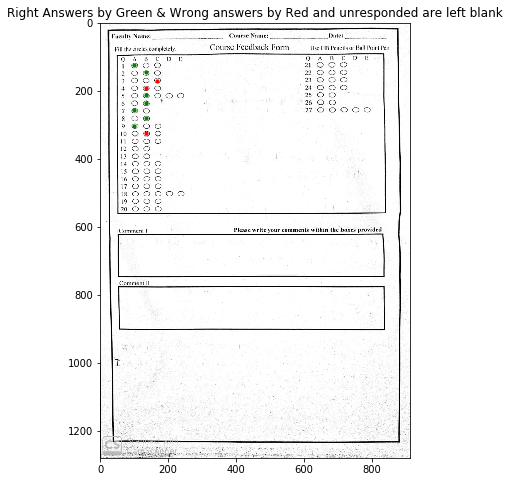

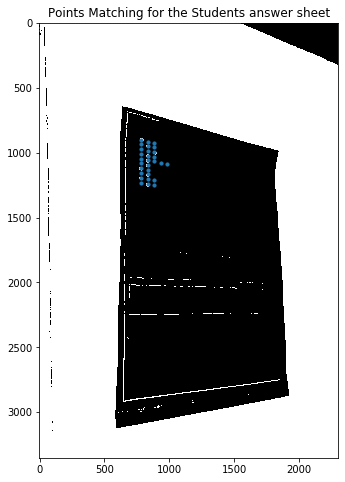

For  27 th image :
Questions with right answers
[1, 2, 5, 6, 7, 8, 9]
Questions with wrong answers
[3, 4, 10]


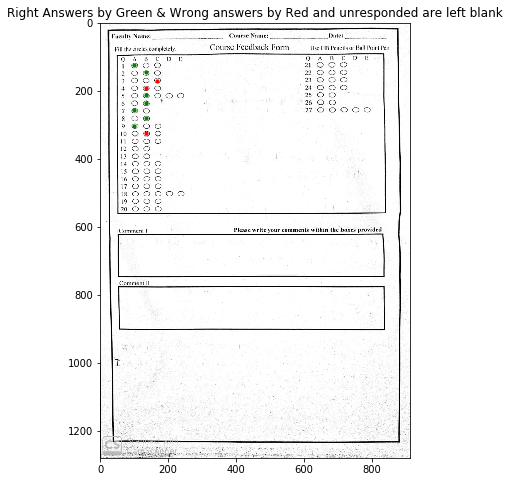

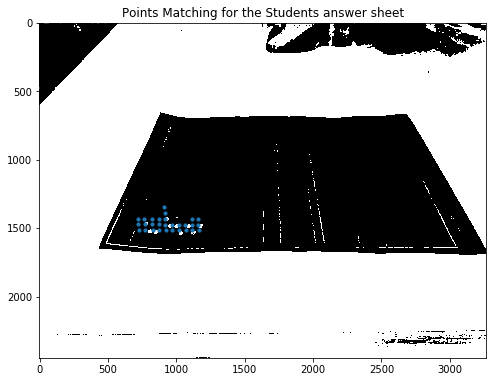

For  28 th image :
Questions with right answers
[2, 6, 9]
Questions with wrong answers
[1, 3, 4, 5, 7, 8, 10]


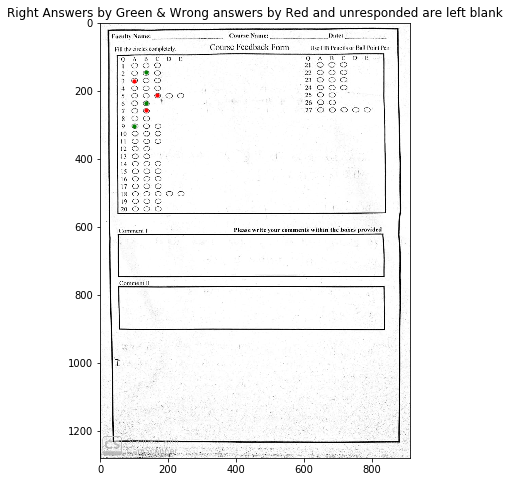

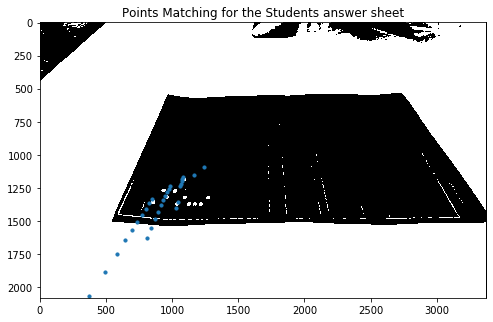

For  29 th image :
Questions with right answers
[7]
Questions with wrong answers
[1, 2, 3, 4, 5, 6, 8, 9, 10]


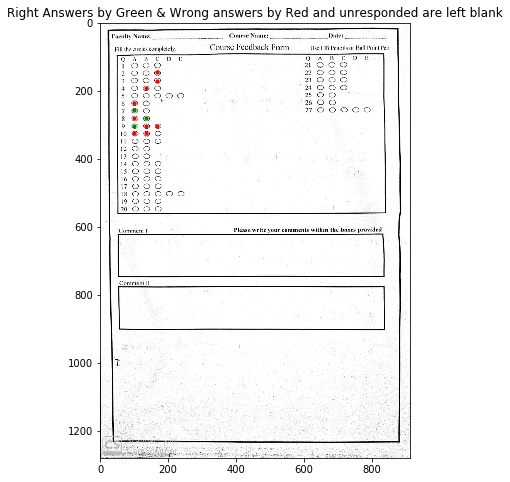

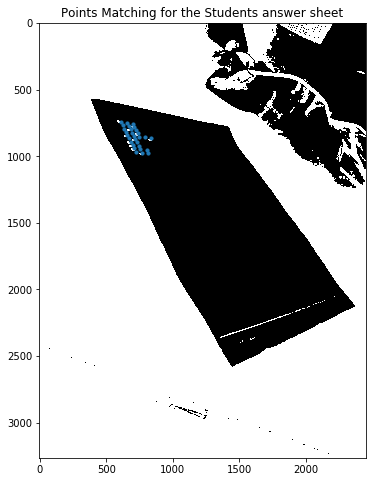

For  30 th image :
Questions with right answers
[1, 3, 4, 6, 7, 9]
Questions with wrong answers
[2, 5, 8, 10]


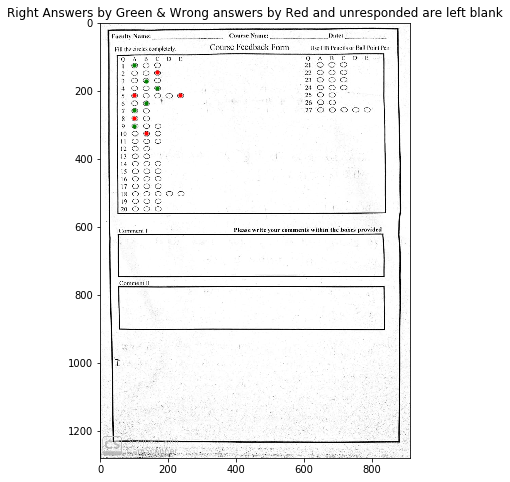

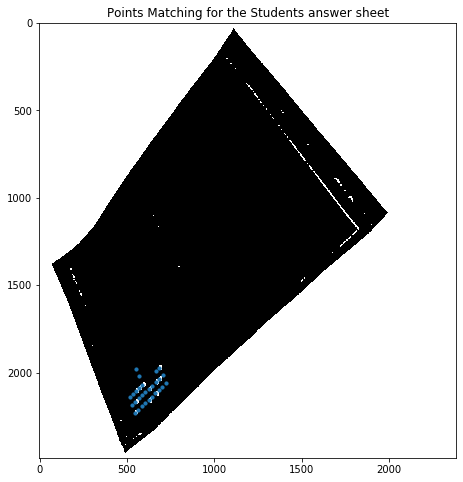

For  31 th image :
Questions with right answers
[1, 4, 10]
Questions with wrong answers
[2, 3, 5, 6, 7, 8, 9]


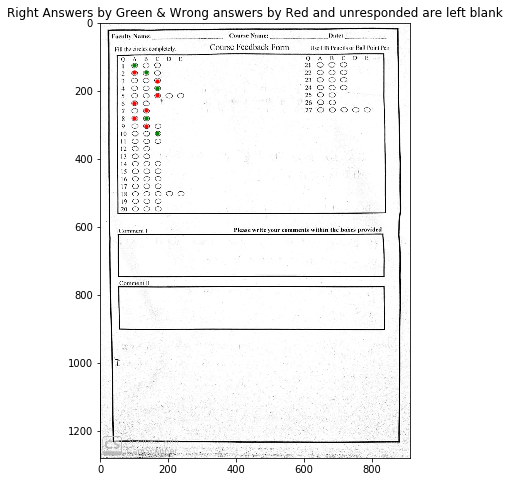

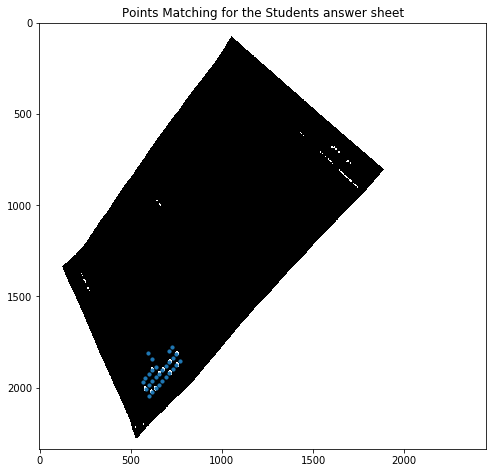

For  32 th image :
Questions with right answers
[4, 5, 6, 7, 8, 9]
Questions with wrong answers
[1, 2, 3, 10]


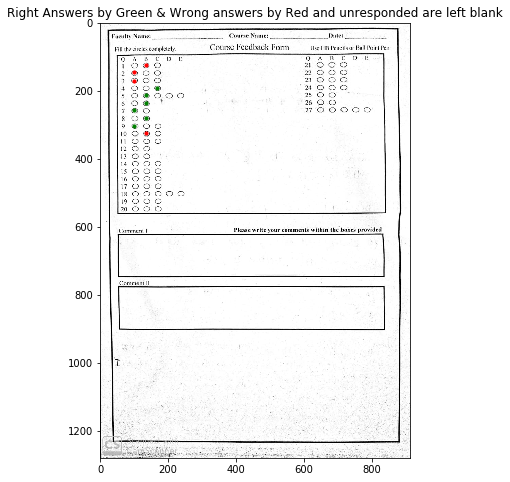

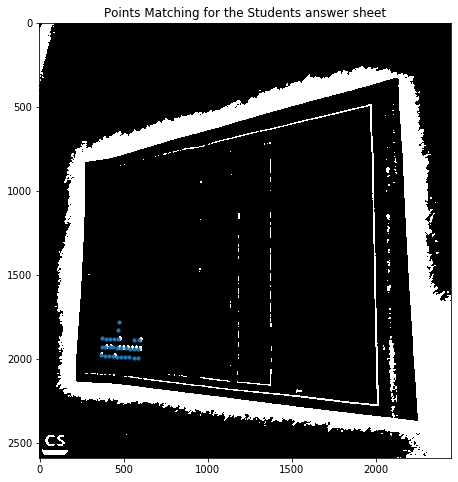

For  33 th image :
Questions with right answers
[1, 2, 3, 6, 8]
Questions with wrong answers
[4, 5, 7, 9, 10]


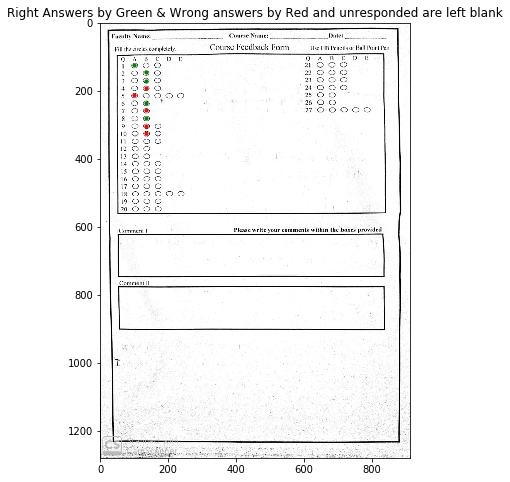

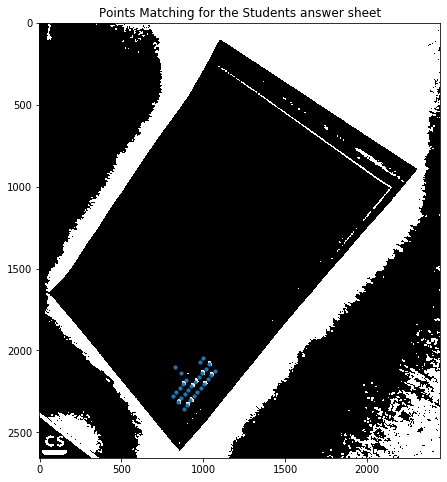

For  34 th image :
Questions with right answers
[4, 5, 6, 7, 8, 9]
Questions with wrong answers
[1, 2, 3, 10]


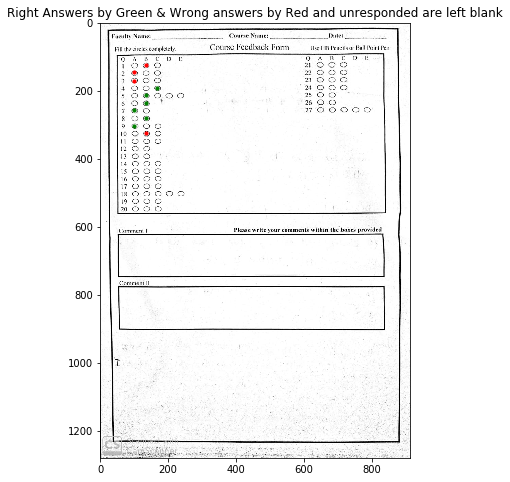

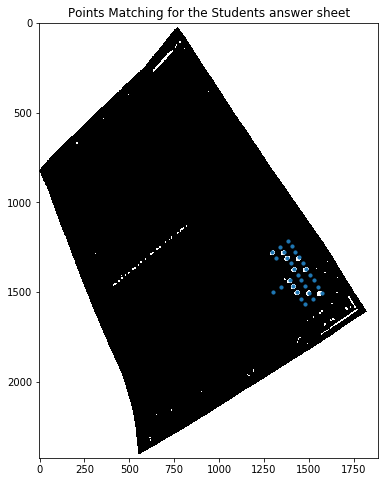

For  35 th image :
Questions with right answers
[1, 2, 4, 6, 7, 8, 10]
Questions with wrong answers
[3, 5, 9]


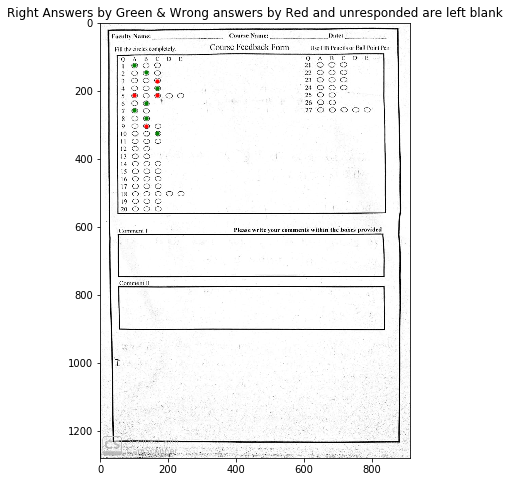

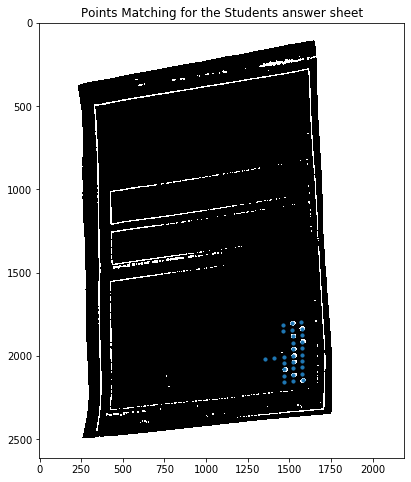

For  36 th image :
Questions with right answers
[1, 2, 5, 6, 7, 8, 9]
Questions with wrong answers
[3, 4, 10]


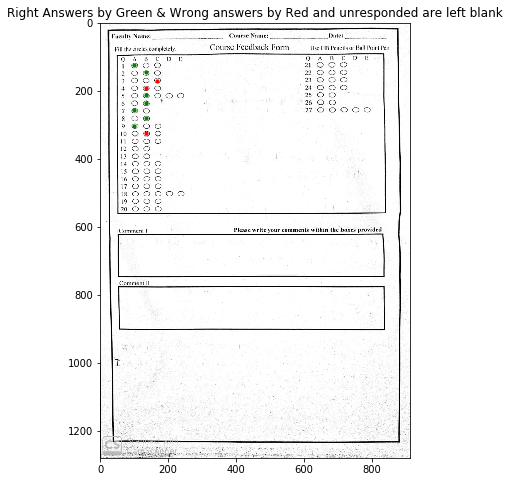

[]


In [5]:
path='./Dataset/test'
n = 1
li = []
for i in range (1,37):
    if i<= 17:
        pathi=path+str(i)+".jpeg"
    else:
        pathi = path+str(i)+".jpg"
    testImg=readImage(pathi)
    testAnswers=getAnswers(templateImg,testImg,ansCordinates,2)
    right,wrong=calculateScore(originalAnswers,testAnswers,distribution)
    print("For ",i,"th image :")
    print("Questions with right answers")
    print(right)
    print("Questions with wrong answers") 
    print(wrong)
    try:
        plotting_final_image_with_color(originalAnswers,testAnswers,templateImg,ansCordinates) 
    except:
        li.append(i)
        print("Error")
        
print(li)